# Optuna

In [1]:
from model_complex import Calibration, EpidData, FactoryBRModel
import matplotlib.pyplot as plt

data = EpidData('spb', './', f'7-01-20{10+0}', f'6-20-20{10+0+1}')
init_infect = [100, 100]
model = FactoryBRModel.get_model('age-group')

d = Calibration(init_infect, model, data)
alpha, beta, rho = d.optuna_calibration()

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
model.simulate(
    alpha=alpha, 
    beta=beta, 
    initial_infectious=init_infect, 
    rho=rho, 
    modeling_duration=len(data)
)

0.664902122153223
0.6873601751748587


[]

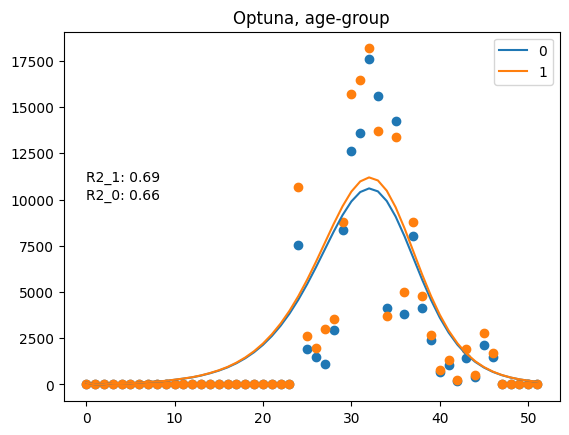

In [25]:
from sklearn.metrics import r2_score

for e, m in enumerate(zip(*model.get_result())):
    m, d = m
    print(r2_score(d, m))
    plt.text(0, 10000+e*1000, f'R2_{e}: {round(r2_score(d, m),2)}')
    plt.plot(m, label=str(e))
    plt.scatter([i for i in range(len(d))], d)
plt.title("Optuna, age-group")
plt.legend()
plt.plot()

# ABC

In [1]:
import time
from model_complex import Calibration, EpidData, FactoryBRModel
import matplotlib.pyplot as plt

start_time = time.time()
data = EpidData('spb', './', f'7-01-20{10+0}', f'6-20-20{10+0+1}')
init_infect = [100]
model = FactoryBRModel.get_model('total')

d = Calibration(init_infect, model, data)
posterior, rho = d.abc_calibration()

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Initializing SMC sampler...
Sampling 6 chains in 6 jobs


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


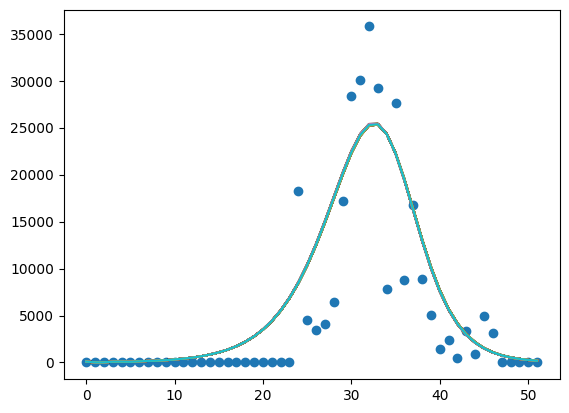

In [26]:

for a, b in zip(*alpha, *beta):
    model.simulate(
        alpha=[a], 
        beta=[b], 
        initial_infectious=init_infect, 
        rho=rho, 
        modeling_duration=len(data)
    )

    newly_inf, d = model.get_result()
    
    plt.plot(newly_inf)
plt.scatter([i for i in range(len(d))], d)

# Plot

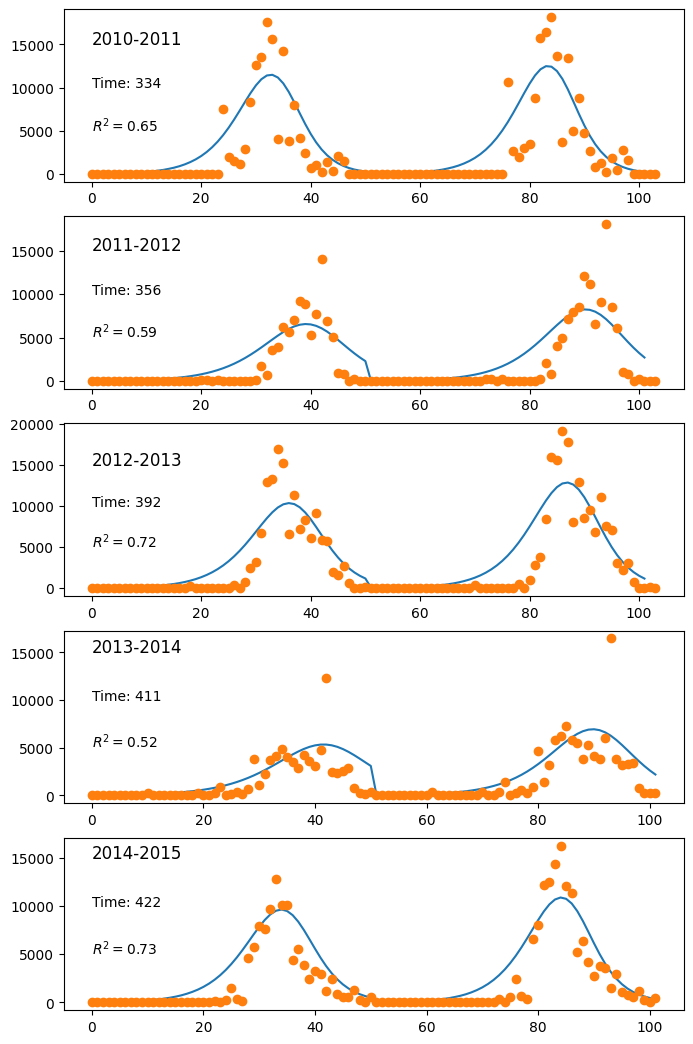

In [8]:
from sklearn.metrics import r2_score

fig, ax = plt.subplots(5, 1, figsize=(8, 13))
start_day = 15    

for e, i in enumerate(zip(Alpha, Beta, Data, Time)):

    alpha, beta, data, time = i
    
    res = simulation_func(alpha, beta)

    ax[e].plot(res)

    ax[e].plot(data, "o")

    r2_score_val = r2_score(data, res)
    ax[e].text(0, 10000, f'Time: {round(i[3])}')
    ax[e].text(0, 5e3, r'$R^2={}$'.format(round(r2_score_val,2)))

    ax[e].text(0, 15000, f'{2010+e}-{2011+e}', fontsize=12)

fig.savefig(f'optuna_2015-2020.png', dpi=400)
